In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import pywt
import heartpy as hp
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, resample
from scipy import signal

from detect_body_movements import detect_patterns
from band_pass_filtering import band_pass_filtering
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
import math
from remove_nonLinear_trend import remove_nonLinear_trend
from compute_vitals import vitals

%matplotlib inline

In [2]:


# SYNC
def build_bcg_df(bcg_values, initial_timestamp, fs):
    """
    Constructs a BCG DataFrame from raw values, initial timestamp, and sampling rate.
    
    Args:
        bcg_values: List of BCG signal values (e.g., [-86, -90, -91, -86])
        initial_timestamp: Timestamp of first sample (epoch ms or datetime string)
        fs: Sampling frequency in Hz
        
    Returns:
        pd.DataFrame with columns: ['Timestamp', 'BCG', 'Time']
    """
    # Convert timestamp to datetime if it's a string
    if isinstance(initial_timestamp, str):
        initial_timestamp = pd.to_datetime(initial_timestamp)
    elif isinstance(initial_timestamp, (int, float)):
        initial_timestamp = pd.to_datetime(initial_timestamp, unit='ms')
    
    # Calculate time intervals
    period = 1 / fs
    timestamps = [initial_timestamp + pd.Timedelta(seconds=i*period) 
                 for i in range(len(bcg_values))]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'BCG': bcg_values
    })
    
    # Add human-readable time
    df['Time'] = df['Timestamp'].dt.strftime('%H:%M:%S.%f')
    
    return df




def synchronize_bcg_and_hr(df_bcg_raw, df_hr_raw):
    """
    Builds and synchronizes BCG and HR DataFrames starting from the first common time.
    
    Args:
        df_bcg_raw: Raw BCG DataFrame from CSV. Must contain 'BCG', 'Timestamp', and 'fs' columns.
        df_hr_raw: Raw HR DataFrame from CSV. Must contain 'Timestamp' column in datetime-compatible format.
    
    Returns:
        bcg_aligned, hr_aligned: Time-synchronized DataFrames
    """
        # Parse BCG values and metadata
    bcg_values = df_bcg_raw['BCG'].tolist()
    initial_timestamp = pd.to_datetime(df_bcg_raw.loc[0, 'Timestamp'], unit='ms')
    fs = float(df_bcg_raw.loc[0, 'fs'])

    # Build BCG DataFrame
    df_bcg = build_bcg_df(bcg_values, initial_timestamp, fs)

    # Parse HR timestamps
    df_hr_raw['Timestamp'] = pd.to_datetime(df_hr_raw['Timestamp'])

    # Find common time range
    start_time = max(df_bcg['Timestamp'].min(), df_hr_raw['Timestamp'].min())
    end_time = min(df_bcg['Timestamp'].max(), df_hr_raw['Timestamp'].max())

    # Trim both DataFrames to common range
    bcg_aligned = df_bcg[(df_bcg['Timestamp'] >= start_time) & (df_bcg['Timestamp'] <= end_time)].copy()
    hr_aligned = df_hr_raw[(df_hr_raw['Timestamp'] >= start_time) & (df_hr_raw['Timestamp'] <= end_time)].copy()

    # Reset index
    bcg_aligned.reset_index(drop=True, inplace=True)
    hr_aligned.reset_index(drop=True, inplace=True)

    return bcg_aligned, hr_aligned






In [3]:

#read csv files
df_bcg= pd.read_csv('/home/bahey/bio_data/dataset/data/01/BCG/01_20231105_BCG.csv')        #### n4 &
df_heart=pd.read_csv("/home/bahey/bio_data/dataset/data/01/Reference/RR/01_20231105_RR.csv")   #### 1 second one

# step 1 :Synchronize BCG and HR DataFrames from the first common time
bcg_sync, hr_sync = synchronize_bcg_and_hr(df_bcg, df_heart)

print("Time synchronized BCG DataFrame:")
print(bcg_sync.head())
print("\nTime synchronized Heart Rate DataFrame:")
print(hr_sync.head())


Time synchronized BCG DataFrame:
                      Timestamp  BCG             Time
0 2023-11-04 19:12:20.003285714  -60  19:12:20.003285
1 2023-11-04 19:12:20.010428571  -65  19:12:20.010428
2 2023-11-04 19:12:20.017571428 -101  19:12:20.017571
3 2023-11-04 19:12:20.024714285  -59  19:12:20.024714
4 2023-11-04 19:12:20.031857142  -15  19:12:20.031857

Time synchronized Heart Rate DataFrame:
            Timestamp  Heart Rate  RR Interval in seconds
0 2023-11-04 19:12:20          99                   0.613
1 2023-11-04 19:12:20          99                   0.621
2 2023-11-04 19:12:21          98                   0.626
3 2023-11-04 19:12:22          98                   0.632
4 2023-11-04 19:12:22          98                   0.635


In [ ]:
###  the heart rate windowing take 10 seconds

hr_sync['Timestamp'] = pd.to_datetime(hr_sync['Timestamp'])

# Set Timestamp as the index
hr_sync.set_index('Timestamp', inplace=True)

# Group by non-overlapping 10-second windows and calculate the mean of 'Heart Rate'
windowed_df = hr_sync.resample('10S').mean()

# Print the result
print(windowed_df[['Heart Rate']])


/tmp/ipykernel_4546/3738532375.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  windowed_df = hr_sync.resample('10S').mean()


                     Heart Rate
Timestamp                      
2023-11-04 19:12:20   98.687500
2023-11-04 19:12:30  100.625000
2023-11-04 19:12:40   94.066667
2023-11-04 19:12:50   92.625000
2023-11-04 19:13:00   92.000000
...                         ...
2023-11-04 22:05:10   59.300000
2023-11-04 22:05:20   60.300000
2023-11-04 22:05:30   60.100000
2023-11-04 22:05:40   59.800000
2023-11-04 22:05:50   59.500000

[1042 rows x 1 columns]


In [8]:
# resample bcg to 50 hz 
bcg_sync.set_index('Timestamp', inplace=True)

# Original sampling rate (140 Hz)
fs_original = 140  
# Target sampling rate (50 Hz)
fs_target = 50  

# Calculate resampling factor
resample_factor = fs_target / fs_original

# Number of samples in resampled signal
num_samples = int(len(bcg_sync) * resample_factor)

# Resample the BCG signal using Fourier method (preserves timing information)
resampled_bcg = signal.resample(bcg_sync['BCG'], num_samples)

# Create new timestamps for the resampled data
start_time = bcg_sync.index[0]
end_time = bcg_sync.index[-1]
new_timestamps = pd.date_range(start=start_time, end=end_time, periods=num_samples)

# Create new DataFrame with resampled data
resampled_df = pd.DataFrame({
    'BCG': resampled_bcg,
    'Time': new_timestamps.time
}, index=new_timestamps)

# Reset index if you want Timestamp as a column again
resampled_df.reset_index(inplace=True)
resampled_df.rename(columns={'index': 'Timestamp'}, inplace=True)

print(resampled_df.head())

                      Timestamp         BCG             Time
0 2023-11-04 19:12:20.003285714  -62.199690  19:12:20.003285
1 2023-11-04 19:12:20.023285755  -51.919848  19:12:20.023285
2 2023-11-04 19:12:20.043285796 -125.002844  19:12:20.043285
3 2023-11-04 19:12:20.063285837 -811.109988  19:12:20.063285
4 2023-11-04 19:12:20.083285878 -414.326722  19:12:20.083285


/tmp/ipykernel_4546/1326145423.py:4: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**9


0         1699125140
1         1699125140
2         1699125140
3         1699125140
4         1699125140
             ...    
520576    1699135551
520577    1699135551
520578    1699135551
520579    1699135551
520580    1699135551
Name: epoch, Length: 520581, dtype: int64
0         -62.199690
1         -51.919848
2        -125.002844
3        -811.109988
4        -414.326722
             ...    
520576    -25.777328
520577    -31.191030
520578    -28.447707
520579    -34.915308
520580    -25.351139
Name: BCG, Length: 520581, dtype: float64
[-32.22768216 -32.81422654 -33.12324449 ... -29.02594257 -30.30733276
 -31.38388896]


TypeError: object of type 'numpy.float64' has no len()

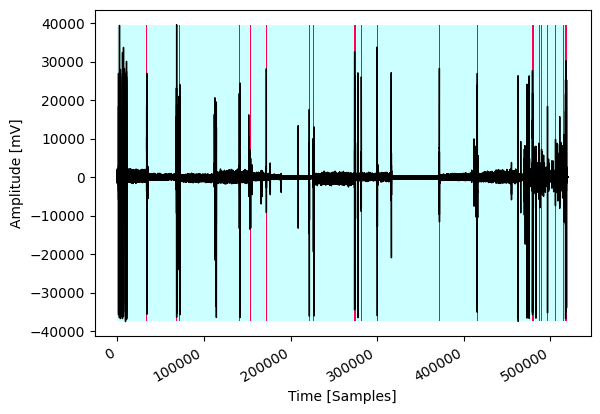

In [ ]:
# bcg= windows[1040]
bcg = resampled_df
start_point, end_point, window_shift, fs = 0, 500, 500, 50
bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**9
utc_time = bcg['epoch']
data_stream = bcg['BCG']
print(utc_time)
print(data_stream)
data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)





In [ ]:
movement = band_pass_filtering(data_stream, fs, "bcg")
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
print(wavelet_cycle)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)
